In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import random
import os

In [74]:
IMG_SIZE = (150, 150)

# remove the projection head from the pre-trained model and only keep the encoder
pretrained_model = keras.models.load_model("../output/supcon_pretraining/20221109-092421/supcon_model_600_6.95", compile=False)
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
outputs = pretrained_model.layers[1](inputs)
encoder = keras.Model(inputs=inputs, outputs=outputs)
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 model (Functional)          (None, 512)               11186119  
                                                                 
Total params: 11,186,119
Trainable params: 11,176,512
Non-trainable params: 9,607
_________________________________________________________________


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.062187


/home/alvin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.176678
[t-SNE] KL divergence after 1000 iterations: 0.975707


Text(0.5, 1.0, 't-SNE plot using 512-dimensional vector generated from encoder (CelebA dataset)')

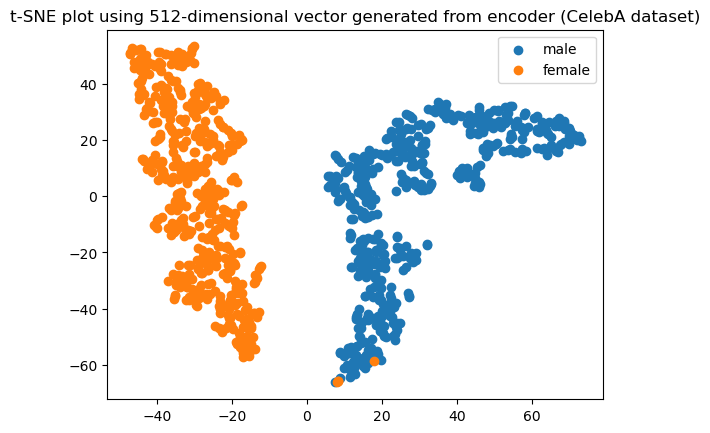

In [75]:
# CelebA

train_df = pd.read_csv("../data/CelebA/train.txt", delimiter=" ", header=None)
train_df.columns = ["filename", "gender"]
test_df = pd.read_csv("../data/CelebA/test.txt", delimiter=" ", header=None)
test_df.columns = ["filename", "gender"]

df = pd.concat([train_df, test_df])
male_df = df[df["gender"] == 1]
female_df = df[df["gender"] == 0]

# randomly choose 500 female
male_filenames = random.sample(male_df["filename"].tolist(), 500)
assert len(male_filenames) == 500

# randomly choose 500 male
female_filenames = random.sample(female_df["filename"].tolist(), 500)
assert len(female_filenames) == 500

male_vector_rep = []
for f in male_filenames:
    img = tf.io.read_file(os.path.join("../data/CelebA/img_align_celeba", f))
    img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
    img = tf.image.resize(img, size=IMG_SIZE)

    male_vector_rep.append(encoder(tf.expand_dims(img, axis=0), training=False))
    
female_vector_rep = []
for f in female_filenames:
    img = tf.io.read_file(os.path.join("../data/CelebA/img_align_celeba", f))
    img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
    img = tf.image.resize(img, size=IMG_SIZE)

    female_vector_rep.append(encoder(tf.expand_dims(img, axis=0), training=False))
    
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000, learning_rate='auto', init="pca")
tsne_results = tsne.fit_transform(np.squeeze(np.array(male_vector_rep + female_vector_rep), axis=1))
assert tsne_results.shape == (1000, 2)

plt.scatter(tsne_results[:500, 0], tsne_results[:500, 1], label="male")
plt.scatter(tsne_results[500:, 0], tsne_results[500:, 1], label="female")
plt.legend()
plt.title("t-SNE plot using 512-dimensional vector generated from encoder (CelebA dataset)")

In [92]:
# Adience

train_df = pd.read_csv("../data/Adience/fold_0/train.txt", delimiter=" ", header=None)
train_df.columns = ["filename", "gender"]
test_df = pd.read_csv("../data/Adience/fold_0/val.txt", delimiter=" ", header=None)
test_df.columns = ["filename", "gender"]
df = pd.concat([train_df, test_df])

male_df = df[df["gender"] == 1]
female_df = df[df["gender"] == 0]

# randomly choose 500 female
male_filenames = random.sample(male_df["filename"].tolist(), 500)
assert len(male_filenames) == 500

# randomly choose 500 male
female_filenames = random.sample(female_df["filename"].tolist(), 500)
assert len(female_filenames) == 500

male_vector_rep = []
for f in male_filenames:
    img = tf.io.read_file(os.path.join("../data/Adience/aligned", f))
    img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
    img = tf.image.resize(img, size=IMG_SIZE)

    male_vector_rep.append(encoder(tf.expand_dims(img, axis=0), training=False))
    
female_vector_rep = []
for f in female_filenames:
    img = tf.io.read_file(os.path.join("../data/Adience/aligned", f))
    img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
    img = tf.image.resize(img, size=IMG_SIZE)

    female_vector_rep.append(encoder(tf.expand_dims(img, axis=0), training=False))

/home/alvin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.062083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.972015
[t-SNE] KL divergence after 1000 iterations: 0.927165


Text(0.5, 1.0, 't-SNE plot using 512-dimensional vector generated from encoder (Adience dataset)')

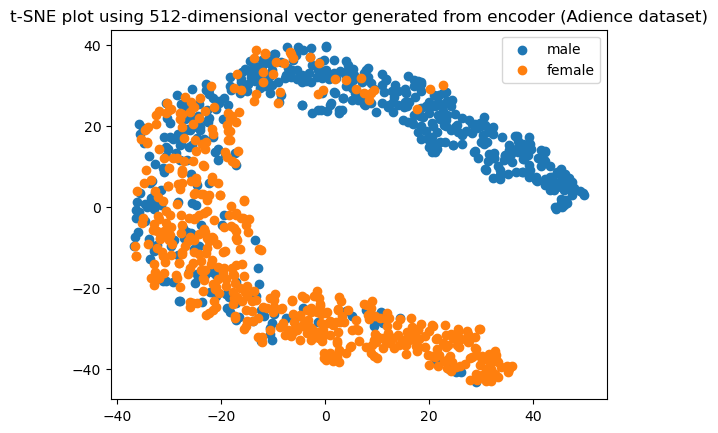

In [93]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000, learning_rate='auto')
tsne_results = tsne.fit_transform(np.squeeze(np.array(male_vector_rep + female_vector_rep), axis=1))
assert tsne_results.shape == (1000, 2)

plt.scatter(tsne_results[:500, 0], tsne_results[:500, 1], label="male")
plt.scatter(tsne_results[500:, 0], tsne_results[500:, 1], label="female")
plt.legend()
plt.title("t-SNE plot using 512-dimensional vector generated from encoder (Adience dataset)")